<a href="https://colab.research.google.com/github/iz-120/ECM514-Projeto02-Assistente-Diagnostico/blob/main/Projeto_2__Assistente_de_Diagn%C3%B3stico_de_Dengue_Principal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Principal

Aqui será desenvolvido o projeto e contempla as seguintes etapas:

1. Completar

# Inicialização

## Importações

In [1]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay, make_scorer, recall_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import shap
from sklearn.pipeline import Pipeline

## Funções

In [2]:
# ==============================================================================
# CARREGA OS DADOS UTILIZADOS
# ==============================================================================
def carregar_dados_dengue_de_release(url_release: str, ficheiro_csv_no_zip: str) -> pd.DataFrame:
    """
    Descarrega um ficheiro ZIP de uma URL, extrai um CSV específico e o carrega para um DataFrame.

    Args:
        url_release (str): O URL público para o ficheiro .zip na Release do GitHub.
        ficheiro_csv_no_zip (str): O nome exato do ficheiro .csv dentro do .zip.

    Returns:
        pd.DataFrame: Um DataFrame do Pandas contendo os dados do CSV, ou um DataFrame vazio em caso de erro.
    """
    print(f"A descarregar dados de: {url_release}")

    try:
        # Faz o request para obter o conteúdo do ficheiro
        response = requests.get(url_release, timeout=300) # Timeout de 5 minutos
        response.raise_for_status()  # Lança um erro para respostas HTTP > 400

        print("Download concluído com sucesso. A extrair o ficheiro CSV...")

        # Usa BytesIO para tratar o conteúdo do ZIP em memória, sem salvar no disco
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            # Verifica se o ficheiro CSV esperado está no ZIP
            if ficheiro_csv_no_zip not in z.namelist():
                print(f"ERRO: O ficheiro '{ficheiro_csv_no_zip}' não foi encontrado no ZIP.")
                print(f"Ficheiros disponíveis: {z.namelist()}")
                return pd.DataFrame()

            # Extrai e carrega o CSV para o pandas
            with z.open(ficheiro_csv_no_zip) as f:
                df = pd.read_csv(f, low_memory=False)
                print(f"DataFrame carregado com sucesso! Shape: {df.shape}")
                return df

    except requests.exceptions.RequestException as e:
        print(f"ERRO: Falha ao descarregar o ficheiro. Motivo: {e}")
        return pd.DataFrame()
    except zipfile.BadZipFile:
        print("ERRO: O ficheiro descarregado não é um ZIP válido.")
        return pd.DataFrame()
    except Exception as e:
        print(f"Ocorreu um erro inesperado: {e}")
        return pd.DataFrame()

## Recuperar dados


In [3]:
# URL dos dados a serem recuperados
URL_DADOS_BRUTOS = "https://github.com/iz-120/ECM514-Projeto02-Assistente-Diagnostico/releases/download/v1.0-dados/dengue_2025.zip"
URL_DADOS_LIMPOS = "https://github.com/iz-120/ECM514-Projeto02-Assistente-Diagnostico/releases/download/v1.0-dados/dengue_limpo_2025.zip"

# Nome exato do arquivo CSV dentro do .zip
CSV_BRUTO = "dengue_2025.csv"
CSV_LIMPO = "dengue_limpo_2025.csv"

# Chama a função para carregar os dados brutos - Não será utilizada
# df_bruto = carregar_dados_dengue_de_release(
#     url_release=URL_DADOS_BRUTOS,
#     ficheiro_csv_no_zip=CSV_BRUTO
# )

# Chama a função para carregar os dados limpos
df_dengue = carregar_dados_dengue_de_release(
    url_release=URL_DADOS_LIMPOS,
    ficheiro_csv_no_zip=CSV_LIMPO
)
df_dengue = df_dengue.dropna()

# Mostra as primeiras linhas do DataFrame se ele for carregado com sucesso
if not df_dengue.empty:
    print("\nAmostra dos dados carregados:")
    display(df_dengue.head())

A descarregar dados de: https://github.com/iz-120/ECM514-Projeto02-Assistente-Diagnostico/releases/download/v1.0-dados/dengue_limpo_2025.zip
Download concluído com sucesso. A extrair o ficheiro CSV...
DataFrame carregado com sucesso! Shape: (1516068, 20)

Amostra dos dados carregados:


,DT_NOTIFIC,IDADE_ANOS,DIAS_COM_SINTOMAS,RISCO_GRAVIDADE_grave,CS_SEXO_F,CS_SEXO_I,CS_RACA_Amarela,CS_RACA_Branca,CS_RACA_Indigena,CS_RACA_Parda,CS_RACA_Preta,FEBRE_sim,MIALGIA_sim,CEFALEIA_sim,EXANTEMA_sim,VOMITO_sim,NAUSEA_sim,PETEQUIA_N_sim,ARTRALGIA_sim,DOR_RETRO_sim
0,2025-04-22,33.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,2025-04-15,62.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-04-03,24.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
3,2025-04-15,7.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2025-04-30,19.0,3.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Recorte dos dados

Para reduzir o tempo de execução dos modelos, foi feita uma redução da quantidade de linhas de forma a manter a proporção da coluna RISCO_GRAVIDADE_grave

In [4]:
frac = 0.01  # Fração do dataset original

# Cria df reduzido
df_dengue_reduzido, _ = train_test_split(df_dengue, train_size=frac, stratify=df_dengue['RISCO_GRAVIDADE_grave'], random_state=42)

# Verificar proporções
print("Original:")
print(f'{len(df_dengue):,} linhas')
display(df_dengue['RISCO_GRAVIDADE_grave'].value_counts(normalize=True))

print("Reduzido:")
print(f'{len(df_dengue_reduzido):,} linhas')
display(df_dengue_reduzido['RISCO_GRAVIDADE_grave'].value_counts(normalize=True))

Original:
1,165,854 linhas


,proportion
RISCO_GRAVIDADE_grave,
0.0,0.974437
1.0,0.025563


Reduzido:
11,658 linhas


,proportion
RISCO_GRAVIDADE_grave,
0.0,0.974438
1.0,0.025562


In [ ]:
# from google.colab import drive

# # Abrindo Drive
# drive.mount('/content/drive')

# # Definindo o path
# path = '/content/drive/MyDrive/Mauá/5° Ano/ECM514 - Ciência de Dados/Projeto 2/Dados'

# # Salva dataframe original em csv no Drive
# arquivo_reduzido_1 = path + '/df_dengue_reduzido_1.csv'
# df_dengue_reduzido.to_csv(arquivo_reduzido_1, index=False)

Mounted at /content/drive


# Modelagem e Treinamento

### Análise do Desbalanceamento de Classes

Verificar a proporção de casos graves (classe 1) e não graves (classe 0). Visa entender a necessidade de técnicas para equalizar a distribuição dos dados.

Distribuição de classes:


,proportion
RISCO_GRAVIDADE_grave,
0.0,97.443676
1.0,2.556324


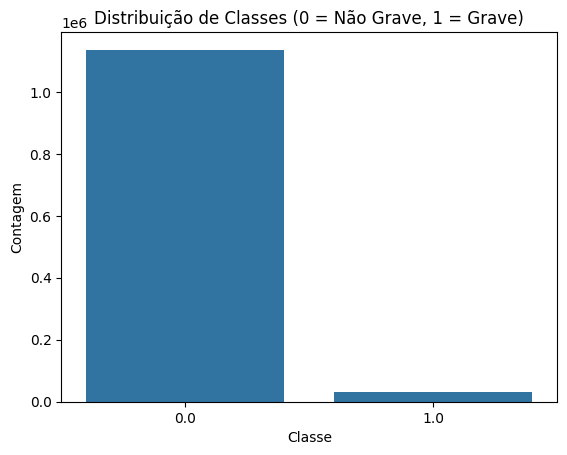

In [ ]:
print("Distribuição de classes:")
class_distribution = df_dengue['RISCO_GRAVIDADE_grave'].value_counts(normalize=True) * 100
display(class_distribution)

# Visualização gráfica
sns.countplot(x=df_dengue['RISCO_GRAVIDADE_grave'])
plt.title('Distribuição de Classes (0 = Não Grave, 1 = Grave)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

A classe `1` (Risco de Gravidade) é significativamente minoritária. Um modelo treinado com estes dados tenderia a prever sempre `0`, obtendo uma alta acurácia mas sendo inútil na prática. Por isso, usaremos SMOTE.

### Preparação dos Dados para Modelagem

In [5]:
# Remove coluna de data
df_datas = df_dengue['DT_NOTIFIC']
df_dengue = df_dengue.drop('DT_NOTIFIC', axis=1)

# Remove colunas de etnia
for etnia in ['CS_RACA_Amarela', 'CS_RACA_Branca', 'CS_RACA_Indigena', 'CS_RACA_Parda', 'CS_RACA_Preta']:
    if etnia in df_dengue.columns:
        df_dengue = df_dengue.drop(columns=[etnia])

# Definir X (features) e y (alvo)
X = df_dengue.drop('RISCO_GRAVIDADE_grave', axis=1)
y = df_dengue['RISCO_GRAVIDADE_grave']

In [6]:
# Dividir os dados em treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
    )

print("Separação de dados concluída:")
print(f"Tamanho do conjunto de treino: {X_train.shape[0]:,} amostras")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]:,} amostras")

Separação de dados concluída:
Tamanho do conjunto de treino: 932,683 amostras
Tamanho do conjunto de teste: 233,171 amostras


## Regressão Logística

### Treinamento do Modelo com Pipeline

Será utilizada um `Pipeline` da Scikit-learn para organizar o fluxo de trabalho. Isto garante que o SMOTE seja aplicado **apenas** aos dados de treino, evitando o vazamento de dados (*data leakage*)

In [7]:
pipeline_logreg = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Grade de parâmetros para testar
# 'classifier__' é o prefixo para aceder aos parâmetros do estimador dentro do pipeline
parametros_de_busca = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'] # Solvers que suportam ambas as penalidades l1 e l2
}

# --- Configuração da Busca Aleatória com Validação Cruzada ---
# A métrica principal para otimização será o recall da classe 1 (casos graves)
recall_scorer = make_scorer(recall_score, pos_label=1)

print("\nIniciando a otimização de hiperparâmetros com RandomizedSearchCV...")
random_search = RandomizedSearchCV(
    estimator=pipeline_logreg,
    param_distributions=parametros_de_busca,
    n_iter=5,  # Número de combinações a serem testadas
    cv=3,       # Número de folds
    scoring=recall_scorer,
    random_state=42,
    n_jobs=-1,  # Utilizar todos os processadores
    verbose=2   # Mostrar o progresso
)

# Executar a busca
random_search.fit(X_train, y_train)

print("\nOtimização concluída.")
print("---------------------------------------------------------")
print(f"Melhor score de Recall (validação cruzada): {random_search.best_score_:.4f}")
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print("---------------------------------------------------------")


Iniciando a otimização de hiperparâmetros com RandomizedSearchCV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Otimização concluída.
---------------------------------------------------------
Melhor score de Recall (validação cruzada): 0.5472
Melhores hiperparâmetros encontrados:
{'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 10}
---------------------------------------------------------


### Avaliação da Performance

Com as métricas:
 * Relatório de Classificação
 * Matriz de Confusão
 * Curva ROC e AUC

 Notando que o enfoque da avaliação será principalmente pela capacidade de detectar casos graves


--- AVALIAÇÃO DO MELHOR MODELO DE REGRESSÃO LOGÍSTICA (OTIMIZADO) ---

--- Relatório de Classificação ---
              precision    recall  f1-score   support

         0.0       0.98      0.63      0.77    227210
         1.0       0.04      0.56      0.07      5961

    accuracy                           0.63    233171
   macro avg       0.51      0.59      0.42    233171
weighted avg       0.96      0.63      0.75    233171


--- Matriz de Confusão ---


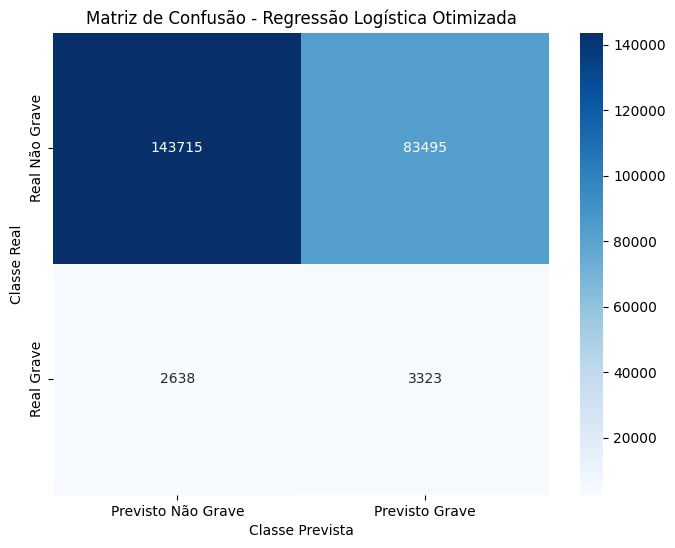


--- Curva ROC e AUC ---
Área Sob a Curva (AUC): 0.6194


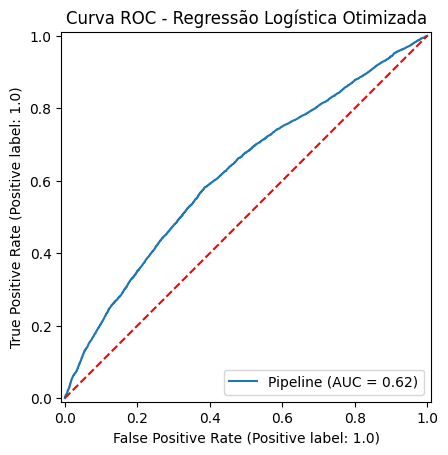

In [8]:
print("\n--- AVALIAÇÃO DO MELHOR MODELO DE REGRESSÃO LOGÍSTICA (OTIMIZADO) ---")
best_logreg_model = random_search.best_estimator_

y_pred = best_logreg_model.predict(X_test)
y_proba = best_logreg_model.predict_proba(X_test)[:, 1]

# 1. Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

# 2. Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto Não Grave', 'Previsto Grave'],
            yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão - Regressão Logística Otimizada')
plt.show()

# 3. Curva ROC e AUC
print("\n--- Curva ROC e AUC ---")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"Área Sob a Curva (AUC): {roc_auc:.4f}")

RocCurveDisplay.from_estimator(best_logreg_model, X_test, y_test)
plt.title('Curva ROC - Regressão Logística Otimizada')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

## Random Forest

### Treinamento do Modelo com Pipeline

Pode demorar alguns minutos

In [ ]:
print("Criar e treinar o pipeline Random Forest...")

pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Grade de parâmetros para testar
parametros_de_busca = {
    'classifier__n_estimators': [100, 200], # Número de árvores
    'classifier__max_depth': [10, 20, None], # Profundidade máxima
    'classifier__min_samples_split': [2, 5], # Mínimo de amostras para dividir um nó
    'classifier__min_samples_leaf': [1, 2],   # Mínimo de amostras por folha
    'classifier__max_features': ['sqrt'] # Número de features a considerar por split
}

# --- Configuração da Busca Aleatória com Validação Cruzada ---
recall_scorer = make_scorer(recall_score, pos_label=1)

print("\nA iniciar a otimização de hiperparâmetros para o Random Forest...")
random_search = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=parametros_de_busca,
    n_iter=10,  # Número de combinações a testar. Aumentar para uma busca mais exaustiva.
    cv=2,       # Usar 3 folds para acelerar o processo em datasets grandes.
    scoring=recall_scorer,
    random_state=42,
    n_jobs=1,
    verbose=2
)

# Executar a busca
random_search.fit(X_train, y_train)

print("\nOtimização concluída.")
print("---------------------------------------------------------")
print(f"Melhor score de Recall (validação cruzada): {random_search.best_score_:.4f}")
print("Melhores hiperparâmetros encontrados:")
print(random_search.best_params_)
print("---------------------------------------------------------")

Criar e treinar o pipeline Random Forest...

A iniciar a otimização de hiperparâmetros para o Random Forest...
Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 2.9min
[CV] END classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 2.7min
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 3.3min
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 3.1min
[CV] END classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classi

### Avaliação da Performance

Com as métricas:
 * Relatório de Classificação
 * Matriz de Confusão
 * Curva ROC e AUC
 * Feature Importance

 Notando que o enfoque da avaliação será principalmente pela capacidade de detectar casos graves

 Aqui também podemos avaliar quais as características mais importantes na hora de fazer a classificação entre casos graves e não graves


--- AVALIAÇÃO DO MELHOR MODELO RANDOM FOREST (OTIMIZADO) ---

--- Relatório de Classificação ---
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92    227210
         1.0       0.05      0.24      0.08      5961

    accuracy                           0.85    233171
   macro avg       0.51      0.56      0.50    233171
weighted avg       0.95      0.85      0.90    233171


--- Matriz de Confusão ---


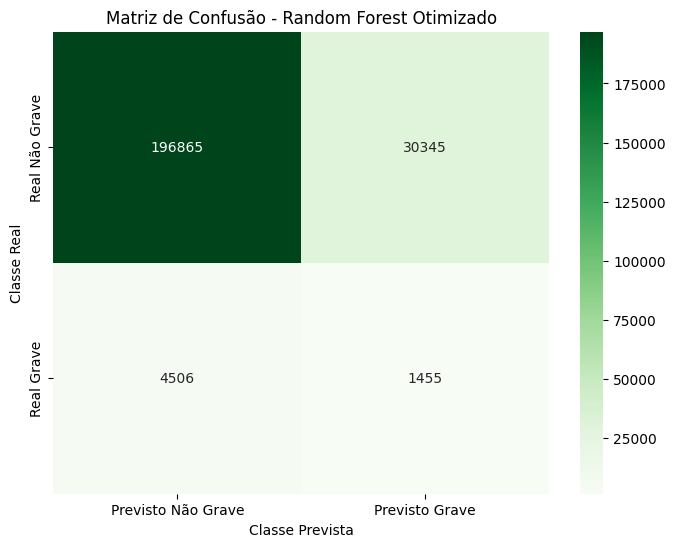


--- Curva ROC e AUC ---


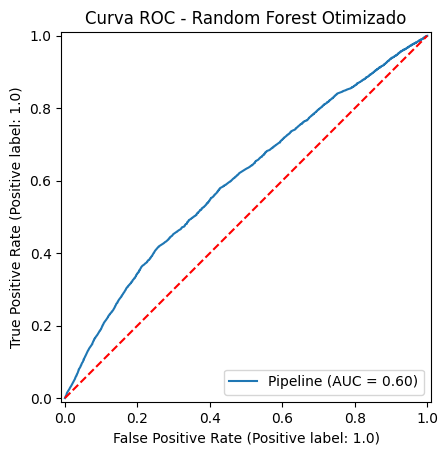


--- Importância das Features ---
              feature  importance
13         VOMITO_sim    0.182707
14         NAUSEA_sim    0.135589
17      DOR_RETRO_sim    0.120673
11       CEFALEIA_sim    0.119607
10        MIALGIA_sim    0.066320
9           FEBRE_sim    0.065738
2           CS_SEXO_F    0.057818
5      CS_RACA_Branca    0.055891
16      ARTRALGIA_sim    0.055079
12       EXANTEMA_sim    0.052094
4     CS_RACA_Amarela    0.033881
15     PETEQUIA_N_sim    0.029438
7       CS_RACA_Parda    0.012685
1   DIAS_COM_SINTOMAS    0.008531
0          IDADE_ANOS    0.002326
8       CS_RACA_Preta    0.001535
6    CS_RACA_Indigena    0.000069
3           CS_SEXO_I    0.000018


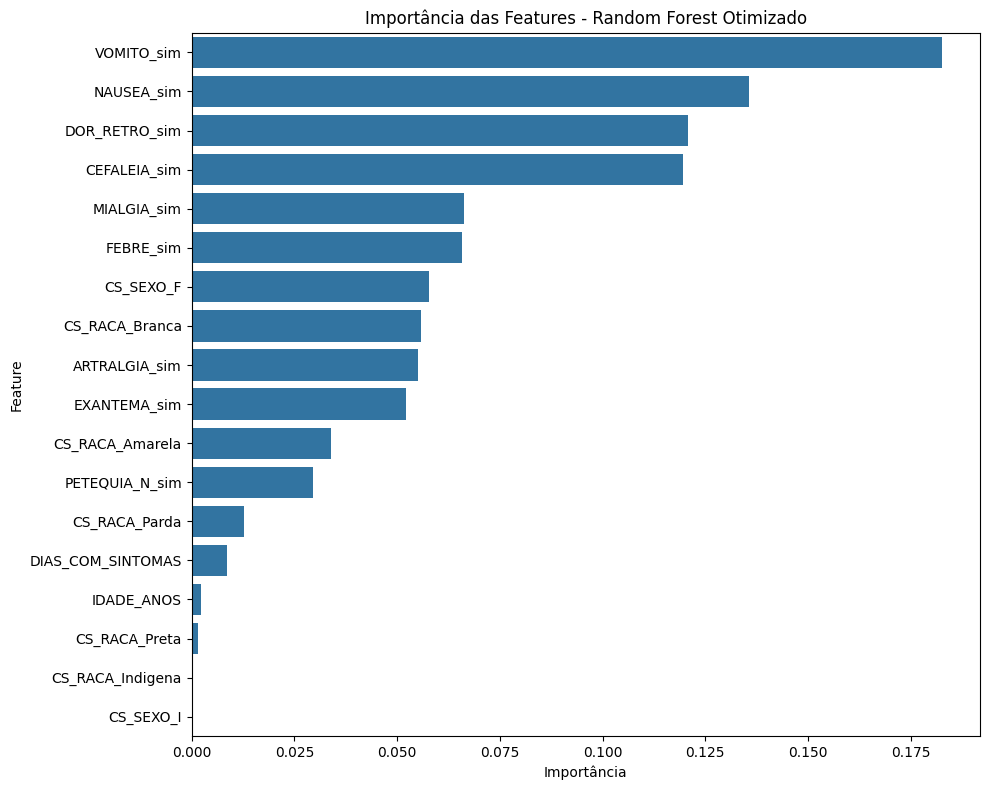

In [ ]:
# --- Avaliação do Melhor Modelo Encontrado ---
print("\n--- AVALIAÇÃO DO MELHOR MODELO RANDOM FOREST (OTIMIZADO) ---")
best_rf_model = random_search.best_estimator_

y_pred = best_rf_model.predict(X_test)
y_proba = best_rf_model.predict_proba(X_test)[:, 1]

# 1. Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

# 2. Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Previsto Não Grave', 'Previsto Grave'],
            yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão - Random Forest Otimizado')
plt.show()

# 3. Curva ROC e AUC
print("\n--- Curva ROC e AUC ---")
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.title('Curva ROC - Random Forest Otimizado')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# 4. Importância das Features
print("\n--- Importância das Features ---")
rf_model = best_rf_model.named_steps['classifier']
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importância das Features - Random Forest Otimizado')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## XGBoost

### Treinamento do Modelo com Pipeline

In [ ]:
print("Criar e treinar o pipeline XGBoost...")
pipeline_xgb = ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()),
            ('classifier', xgb.XGBClassifier(
                random_state=42,
                eval_metric='logloss',
                n_jobs=-1
            ))
        ])

pipeline_xgb.fit(X_train, y_train)
print("Treinamento concluído.")

### Avaliação da Performance

Com as métricas:
 * Relatório de Classificação
 * Matriz de Confusão
 * Curva ROC e AUC
 * Feature Importance

 Notando que o enfoque da avaliação será principalmente pela capacidade de detectar casos graves

 Aqui também podemos avaliar quais as características mais importantes na hora de fazer a classificação entre casos graves e não graves

In [ ]:
print("\n--- AVALIAÇÃO DO MODELO XGBOOST ---")
y_pred = pipeline_xgb.predict(X_test)
y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

# 1. Relatório de Classificação
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred))

# 2. Matriz de Confusão
print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Previsto Não Grave', 'Previsto Grave'],
            yticklabels=['Real Não Grave', 'Real Grave'])
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.title('Matriz de Confusão - XGBoost')
plt.show()

# 3. Curva ROC e AUC
print("\n--- Curva ROC e AUC ---")
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"Área Sob a Curva (AUC): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost').plot()
plt.title('Curva ROC - XGBoost')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

# --- Análise de Importância das Features ---
print("\n--- Importância das Features ---")
xgb_model = pipeline_xgb.named_steps['classifier']
importances = xgb_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Importância das Features - XGBoost')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

OS MODELOS ESTÃO MUITO RUINS, USAR MÉTODOS DE AJUSTAR OS HIPERPARÂMETROS E OS FOLDS

# Salvando modelo final

Para implementar a aplicação, foi escolhido o modelo com melhor desempenho para ser salvo e aplicado

Este script deve ser executado após o tuning de todos os modelos.
Ele pega o melhor modelo encontrado, cria um pipeline de inferência
(sem SMOTE) e o salva em disco para ser usado pelo Streamlit

Ele também cria e salva o "explicador" SHAP

In [9]:

# Extrair o scaler e o classificador treinados do melhor pipeline
scaler_treinado = random_search.best_estimator_.named_steps['scaler']
classificador_treinado = random_search.best_estimator_.named_steps['classifier']

# Criar o Pipeline de INFERÊNCIA com os melhores hiperparâmetros
print("A criar o pipeline de inferência com os melhores hiperparâmetros...")
pipeline_inferencia = Pipeline([
    ('scaler', scaler_treinado),
    ('classifier', classificador_treinado)
])

# Salvar o pipeline de inferência
print("A salvar o pipeline de inferência em 'melhor_modelo_dengue.pkl'...")
joblib.dump(pipeline_inferencia, 'melhor_modelo_dengue.pkl')
print("Pipeline salvo com sucesso.")

# Preparar dados para o explicador SHAP usando o scaler treinado
print("Preparando os dados para o explicador SHAP...")
X_scaled_for_shap = scaler_treinado.transform(X) # Escala X completo usando o scaler treinado

# Criar e Salvar o Explicador SHAP
  # Classificador treinado e os dados escalados para SHAP
explainer = shap.LinearExplainer(classificador_treinado, X_scaled_for_shap)
print("Explicador SHAP criado.")

# Salvar o explicador em disco
print("A salvar o explicador em 'shap_explainer.pkl'...")
joblib.dump(explainer, 'shap_explainer.pkl')
print("Explicador salvo com sucesso.")

# Salvar a lista de colunas
# O modelo precisa de receber as colunas NA MESMA ORDEM em que foi treinado.
colunas = X.columns.tolist()
print(f"Salvando a ordem das colunas: {colunas}")
joblib.dump(colunas, 'colunas_modelo.pkl')
print("Artefactos finais salvos. Pronto para construir a app!")

A criar o pipeline de inferência com os melhores hiperparâmetros...
A salvar o pipeline de inferência em 'melhor_modelo_dengue.pkl'...
Pipeline salvo com sucesso.
Preparando os dados para o explicador SHAP...
Explicador SHAP criado.
A salvar o explicador em 'shap_explainer.pkl'...
Explicador salvo com sucesso.
Salvando a ordem das colunas: ['IDADE_ANOS', 'DIAS_COM_SINTOMAS', 'CS_SEXO_F', 'CS_SEXO_I', 'FEBRE_sim', 'MIALGIA_sim', 'CEFALEIA_sim', 'EXANTEMA_sim', 'VOMITO_sim', 'NAUSEA_sim', 'PETEQUIA_N_sim', 'ARTRALGIA_sim', 'DOR_RETRO_sim']
Artefactos finais salvos. Pronto para construir a app!
